# Description

This notebook generates a heatmap using a subset of the $\hat{\mathbf{M}}$ matrix (projectiong of S-MultiXcan results into latent gene expression representation). Traits in columns (organized by clusters of traits) and LVs in rows. The only difference with `05-global_clustermap.ipynb` is that here LVs shown are those detected to be driving clusters _and_ *NOT* well-aligned (FDR < 0.05) with any pathways (from the MultiPLIER models), thus representing potentially novel mechanisms.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = min((conf.GENERAL["N_JOBS"], 3))
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import conf
from entity import Trait
from data.cache import read_data

# Settings

In [5]:
OUTPUT_FIGURES_DIR = Path(conf.MANUSCRIPT["FIGURES_DIR"], "clustering").resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/clustering')

# Data loading

## MultiPLIER summary

In [6]:
multiplier_model_summary = read_data(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [7]:
multiplier_model_summary.shape

(2157, 5)

In [8]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


In [9]:
well_aligned_lvs = multiplier_model_summary[
    (multiplier_model_summary["FDR"] < 0.05) | (multiplier_model_summary["AUC"] >= 0.75)
]

display(well_aligned_lvs.shape)
display(well_aligned_lvs.head())

(469, 5)

,pathway,LV index,AUC,p-value,FDR
2,REACTOME_MRNA_SPLICING,1,0.733057,4.772691e-05,5.816211e-04
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,1.628217e-03,1.136590e-02
8,REACTOME_MITOTIC_G1_G1_S_PHASES,1,0.686170,2.517619e-04,2.392292e-03
9,IRIS_Monocyte-Day0,2,0.890036,4.315812e-25,1.329887e-22
10,DMAP_MONO2,2,0.904676,1.313970e-16,1.574574e-14


## S-MultiXcan results

In [10]:
smultixcan_results_filename = conf.PHENOMEXCAN[
    "SMULTIXCAN_EFO_PARTIAL_MASHR_ZSCORES_FILE"
]
display(smultixcan_results_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/data/phenomexcan/gene_assoc/smultixcan-efo_partial-mashr-zscores.pkl')

In [11]:
smultixcan_results = pd.read_pickle(smultixcan_results_filename)

In [12]:
smultixcan_results.shape

(22515, 3752)

In [13]:
smultixcan_results.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
gene_name,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,1.145442,0.724557,0.090876,0.298165,1.134347,1.371138,0.065718,0.794317,0.600342,0.317652,...,0.360518,1.351624,1.157695,0.835289,1.173072,1.337280,1.743822,1.017226,1.512184,0.972241
ENSG00000000457,0.618066,1.028131,2.218420,0.762584,0.934418,0.192993,1.080230,0.765997,0.375898,0.678731,...,2.134504,0.127830,0.534690,0.120516,0.517464,2.545363,0.673331,2.003092,0.344000,2.033122
ENSG00000000460,0.515724,0.403596,1.251359,0.433091,0.413466,0.246261,1.236151,0.827430,0.571985,0.782174,...,1.768905,0.992408,0.548215,0.412341,1.499415,1.366780,0.443318,0.417630,0.225934,1.613246
ENSG00000000938,0.280781,0.253910,0.879148,0.352705,0.051846,0.184212,0.148566,0.009989,0.363751,0.374514,...,0.656552,2.046041,2.746832,0.108211,1.008258,0.755695,0.896228,0.875047,0.476405,1.693057
ENSG00000000971,0.548127,0.389877,0.723469,1.167250,0.315952,0.324939,1.613932,0.311432,0.333548,1.807243,...,0.260482,0.646204,1.080240,0.678330,1.465358,0.307672,0.118376,1.419812,0.000002,1.040737


## S-MultiXcan projection (`z_score_std`)

In [14]:
INPUT_SUBSET = "z_score_std"

In [15]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [16]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [17]:
data = read_data(input_filepath)

In [18]:
data.shape

(3752, 987)

In [19]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## Clustering results

In [20]:
CONSENSUS_CLUSTERING_DIR = Path(
    conf.RESULTS["CLUSTERING_DIR"], "consensus_clustering"
).resolve()

display(CONSENSUS_CLUSTERING_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/clustering/consensus_clustering')

In [21]:
input_file = Path(CONSENSUS_CLUSTERING_DIR, "best_partitions_by_k.pkl").resolve()
display(input_file)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/clustering/consensus_clustering/best_partitions_by_k.pkl')

In [22]:
best_partitions = pd.read_pickle(input_file)

In [23]:
# keep selected partitions only
best_partitions = best_partitions[best_partitions["selected"]]

In [24]:
best_partitions.shape

(15, 4)

In [25]:
best_partitions.head()

,method,partition,ari_median,selected
k,,,,
14,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090117,True
22,scc_020,"[13, 18, 18, 18, 18, 18, 18, 18, 18, 13, 18, 1...",0.090100,True
13,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.089920,True
12,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.089894,True
11,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.089616,True


# Get all clusters information

In [26]:
partition_k = 29

In [27]:
part = best_partitions.loc[partition_k, "partition"]

In [28]:
part.shape

(3752,)

In [29]:
part_cluster_size = pd.Series(part).value_counts()
display(part_cluster_size)

0     3293
28     135
25      87
27      47
20      18
19      17
22      15
17      14
18      13
15      12
13      10
14       9
9        8
10       8
6        7
21       7
16       6
11       6
4        6
1        5
12       5
2        4
3        4
5        4
24       3
7        3
8        3
26       2
23       1
dtype: int64

In [30]:
clusters_labels = {
    12: "Asthma",
    27: "Well-being",
    22: "Nutrients",
    15: "Heel bone",
    4: "Reticulocytes",
    2: "Red blood volumes",
    5: "Erythrocytes",
    23: "Read blood DW",
    20: "BMI",
    18: "Spirometry",
    19: "Height",
    10: "Keratometry",
    1: "Platelets",
    6: "Skin/hair color",
    13: "Autoimmune #13",
    26: "Autoimmune #26",
    8: "Autoimmune #8",
    17: "HTN/high cholesterol",
    25: "Other traits #25",
    21: "Eczema/IBD/SCZ",
    28: "Env. factors #28",
    11: "CAD/breast cancer",
    16: "Lipids/AD/Chronotype",
    14: "Other heart diseases",
    7: "Monocytes",
    24: "Lymphocytes",
    9: "Neutrophils",
    3: "Eosinophils",
}

In [31]:
all_clusters = []

for c_idx in part_cluster_size[part_cluster_size < 50].index:
    _df = pd.DataFrame(
        {
            "trait": data.index[part == c_idx].tolist(),
            "cluster_label": clusters_labels[c_idx],
            "cluster_idx": c_idx,
        }
    )

    all_clusters.append(_df)

In [32]:
# combine all
df = pd.concat(all_clusters, ignore_index=True)

In [33]:
df.shape

(237, 3)

In [34]:
df.head()

,trait,cluster_label,cluster_idx
0,20117_2-Alcohol_drinker_status_Current,Well-being,27
1,20126_0-Bipolar_and_major_depression_status_No...,Well-being,27
2,20403-Amount_of_alcohol_drunk_on_a_typical_dri...,Well-being,27
3,20416-Frequency_of_consuming_six_or_more_units...,Well-being,27
4,20421-Ever_felt_worried_tense_or_anxious_for_m...,Well-being,27


# Get top LVs for each cluster

In [35]:
CLUSTER_LV_DIR = (
    conf.RESULTS["CLUSTERING_INTERPRETATION"]["BASE_DIR"]
    / "cluster_lvs"
    / f"part{partition_k}"
)
display(CLUSTER_LV_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/clustering/interpretation/cluster_lvs/part29')

In [36]:
def _get_lvs_data(cluster_idx):
    cluster_lvs = pd.read_pickle(
        CLUSTER_LV_DIR / f"cluster_interpreter-part{partition_k}_k{cluster_idx}.pkl"
    )

    # keep "novel" lvs only
    cluster_lvs = cluster_lvs[
        ~cluster_lvs.index.astype(str).isin(well_aligned_lvs["LV index"])
    ]

    cluster_lvs["cluster"] = cluster_idx

    return pd.Series([set(cluster_lvs["name"]), cluster_lvs])

In [37]:
clusters_df = df.groupby("cluster_idx")[["cluster_label", "cluster_idx"]].head(1)

# add top lvs for each cluster
clusters_df[["lvs_names", "lvs_data"]] = clusters_df["cluster_idx"].apply(_get_lvs_data)

clusters_df = clusters_df.set_index("cluster_label")
assert clusters_df.index.is_unique

display(clusters_df)

,cluster_idx,lvs_names,lvs_data
cluster_label,,,
Well-being,27,"{LV51, LV851, LV277, LV270, LV856, LV391, LV30...",name threshold impurity va...
BMI,20,"{LV926, LV423, LV130, LV629, LV326, LV56, LV9,...",name threshold impurity va...
Height,19,"{LV19, LV672, LV657, LV577, LV75, LV138, LV984...",name threshold impurity va...
Nutrients,22,"{LV834, LV523, LV672, LV453, LV958, LV496, LV9...",name threshold impurity va...
HTN/high cholesterol,17,"{LV515, LV744, LV514, LV147, LV455, LV289, LV3...",name threshold impurity va...
Spirometry,18,"{LV515, LV912, LV355, LV764, LV19, LV577, LV75...",name threshold impurity va...
Heel bone,15,"{LV418, LV117, LV835, LV94, LV294, LV874, LV40...",name threshold impurity va...
Autoimmune #13,13,"{LV453, LV568, LV271, LV610, LV984, LV987, LV5...",name threshold impurity va...
Other heart diseases,14,"{LV146, LV657, LV252, LV664, LV757, LV479, LV7...",name threshold impurity val...


In [38]:
lvs_data = (
    pd.concat(clusters_df["lvs_data"].tolist())
    .reset_index()
    .set_index(["cluster", "idx"])
)

In [39]:
lvs_data.shape

(389, 5)

In [40]:
lvs_data.head(10)

name  threshold  impurity             value  n_samples
cluster idx                                                         
27      301  LV301   4.647161  0.024739  [[3705.0, 47.0]]       3752
        403  LV403   4.231165  0.024739  [[3705.0, 47.0]]       3752
        270  LV270   4.117564  0.024739  [[3705.0, 47.0]]       3752
        387  LV387   3.678295  0.024739  [[3705.0, 47.0]]       3752
        510  LV510   3.671227  0.024739  [[3705.0, 47.0]]       3752
        808  LV808   3.588999  0.024739  [[3705.0, 47.0]]       3752
        391  LV391   3.488969  0.024739  [[3705.0, 47.0]]       3752
        851  LV851   3.377090  0.024739  [[3705.0, 47.0]]       3752
        307  LV307   3.172528  0.024739  [[3705.0, 47.0]]       3752
        856  LV856   3.154191  0.024739  [[3705.0, 47.0]]       3752

In [41]:
_traits = df["trait"]
_lvs = set(lvs_data["name"])

In [42]:
_lvs

{'LV100',
 'LV103',
 'LV106',
 'LV107',
 'LV108',
 'LV115',
 'LV117',
 'LV118',
 'LV122',
 'LV130',
 'LV131',
 'LV132',
 'LV138',
 'LV144',
 'LV145',
 'LV146',
 'LV147',
 'LV151',
 'LV153',
 'LV156',
 'LV160',
 'LV162',
 'LV163',
 'LV169',
 'LV174',
 'LV189',
 'LV19',
 'LV192',
 'LV193',
 'LV194',
 'LV196',
 'LV198',
 'LV205',
 'LV206',
 'LV207',
 'LV208',
 'LV21',
 'LV210',
 'LV215',
 'LV220',
 'LV222',
 'LV224',
 'LV225',
 'LV229',
 'LV232',
 'LV233',
 'LV237',
 'LV238',
 'LV239',
 'LV241',
 'LV250',
 'LV251',
 'LV252',
 'LV253',
 'LV260',
 'LV270',
 'LV271',
 'LV277',
 'LV282',
 'LV289',
 'LV290',
 'LV294',
 'LV301',
 'LV307',
 'LV308',
 'LV309',
 'LV312',
 'LV321',
 'LV323',
 'LV324',
 'LV326',
 'LV329',
 'LV33',
 'LV330',
 'LV331',
 'LV337',
 'LV339',
 'LV342',
 'LV343',
 'LV349',
 'LV355',
 'LV359',
 'LV362',
 'LV363',
 'LV367',
 'LV370',
 'LV381',
 'LV382',
 'LV385',
 'LV387',
 'LV390',
 'LV391',
 'LV392',
 'LV401',
 'LV402',
 'LV403',
 'LV406',
 'LV412',
 'LV413',
 'LV417',
 'L

In [43]:
data_subset = data.loc[_traits, _lvs].rename_axis("trait")
data_subset = data_subset.assign(
    cluster_name=df.set_index("trait")["cluster_label"].astype("category")
)

In [44]:
data_subset.shape

(237, 281)

In [45]:
data_subset

,LV774,LV444,LV401,LV479,LV610,LV153,LV163,LV829,LV174,LV321,...,LV547,LV289,LV87,LV205,LV426,LV194,LV331,LV690,LV775,cluster_name
trait,,,,,,,,,,,,,,,,,,,,,
20117_2-Alcohol_drinker_status_Current,0.050790,0.617443,-1.543378,0.857373,1.154781,-0.383111,0.589581,2.566010,-1.650544,-0.736408,...,1.453983,1.518496,1.681869,0.156923,1.585815,0.094955,0.891785,-0.923468,-0.257720,Well-being
20126_0-Bipolar_and_major_depression_status_No_Bipolar_or_Depression,-0.410769,-1.475715,0.096241,1.702749,1.349829,-0.942862,-0.735689,0.445759,1.650721,0.089970,...,0.432601,-0.547236,0.233726,0.395049,0.390876,0.637525,0.777934,-0.249114,0.660947,Well-being
20403-Amount_of_alcohol_drunk_on_a_typical_drinking_day,0.600034,-1.645810,0.954234,-0.020521,-0.780520,0.789570,-0.232706,1.105855,0.157905,1.706510,...,0.537639,-1.156021,0.319522,1.327954,-1.466898,0.800431,0.355477,-0.429347,1.479764,Well-being
20416-Frequency_of_consuming_six_or_more_units_of_alcohol,-0.834745,-0.723671,0.760679,0.358377,-0.067881,0.648240,0.946423,-0.454072,-1.037169,0.368316,...,1.925836,-0.060399,-0.461104,0.455256,-2.166179,-1.366491,-0.396934,-1.064699,0.420471,Well-being
20421-Ever_felt_worried_tense_or_anxious_for_most_of_a_month_or_longer,1.124222,-0.300745,-1.878755,-0.815991,-0.358562,1.061711,0.772687,-0.568881,0.329426,-0.909316,...,-0.277598,-0.270104,-0.002635,-0.476279,-0.791381,-0.987446,-0.228023,0.745120,-1.155534,Well-being
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
celiac disease,0.159507,1.870299,0.248146,-0.513277,8.539106,-0.091609,-0.545061,0.438350,1.072596,-0.917402,...,-0.959436,-0.795928,-0.939004,-0.368939,-0.630500,0.297396,-0.870911,-1.177155,4.347747,Autoimmune #8
malabsorption syndrome,-0.960059,0.482643,-0.541593,-0.966867,6.171410,0.286861,-0.193714,0.649473,-0.307292,-0.728791,...,0.102585,-0.929418,-0.000283,-1.165180,-0.473718,0.248489,0.388069,-0.274054,2.529336,Autoimmune #8
rheumatoid arthritis,0.289998,-0.096962,-0.815699,-0.192917,2.399198,0.166161,-0.843109,0.822471,-0.622375,-0.931694,...,-1.067098,-0.983652,0.402764,0.243681,-1.073644,1.246170,3.725577,-1.440905,-0.147603,Autoimmune #26


In [46]:
data_subset["trait_description"] = data_subset.apply(
    lambda x: Trait.get_trait(full_code=x.name).description
    if not Trait.is_efo_label(x.name)
    else x.name,
    axis=1,
)

In [47]:
data_subset

,LV774,LV444,LV401,LV479,LV610,LV153,LV163,LV829,LV174,LV321,...,LV289,LV87,LV205,LV426,LV194,LV331,LV690,LV775,cluster_name,trait_description
trait,,,,,,,,,,,,,,,,,,,,,
20117_2-Alcohol_drinker_status_Current,0.050790,0.617443,-1.543378,0.857373,1.154781,-0.383111,0.589581,2.566010,-1.650544,-0.736408,...,1.518496,1.681869,0.156923,1.585815,0.094955,0.891785,-0.923468,-0.257720,Well-being,Alcohol drinker status: Current
20126_0-Bipolar_and_major_depression_status_No_Bipolar_or_Depression,-0.410769,-1.475715,0.096241,1.702749,1.349829,-0.942862,-0.735689,0.445759,1.650721,0.089970,...,-0.547236,0.233726,0.395049,0.390876,0.637525,0.777934,-0.249114,0.660947,Well-being,Bipolar and major depression status: No Bipola...
20403-Amount_of_alcohol_drunk_on_a_typical_drinking_day,0.600034,-1.645810,0.954234,-0.020521,-0.780520,0.789570,-0.232706,1.105855,0.157905,1.706510,...,-1.156021,0.319522,1.327954,-1.466898,0.800431,0.355477,-0.429347,1.479764,Well-being,Amount of alcohol drunk on a typical drinking day
20416-Frequency_of_consuming_six_or_more_units_of_alcohol,-0.834745,-0.723671,0.760679,0.358377,-0.067881,0.648240,0.946423,-0.454072,-1.037169,0.368316,...,-0.060399,-0.461104,0.455256,-2.166179,-1.366491,-0.396934,-1.064699,0.420471,Well-being,Frequency of consuming six or more units of al...
20421-Ever_felt_worried_tense_or_anxious_for_most_of_a_month_or_longer,1.124222,-0.300745,-1.878755,-0.815991,-0.358562,1.061711,0.772687,-0.568881,0.329426,-0.909316,...,-0.270104,-0.002635,-0.476279,-0.791381,-0.987446,-0.228023,0.745120,-1.155534,Well-being,"Ever felt worried, tense, or anxious for most ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
celiac disease,0.159507,1.870299,0.248146,-0.513277,8.539106,-0.091609,-0.545061,0.438350,1.072596,-0.917402,...,-0.795928,-0.939004,-0.368939,-0.630500,0.297396,-0.870911,-1.177155,4.347747,Autoimmune #8,celiac disease
malabsorption syndrome,-0.960059,0.482643,-0.541593,-0.966867,6.171410,0.286861,-0.193714,0.649473,-0.307292,-0.728791,...,-0.929418,-0.000283,-1.165180,-0.473718,0.248489,0.388069,-0.274054,2.529336,Autoimmune #8,malabsorption syndrome
rheumatoid arthritis,0.289998,-0.096962,-0.815699,-0.192917,2.399198,0.166161,-0.843109,0.822471,-0.622375,-0.931694,...,-0.983652,0.402764,0.243681,-1.073644,1.246170,3.725577,-1.440905,-0.147603,Autoimmune #26,rheumatoid arthritis


In [48]:
data_subset = data_subset.replace(
    {
        "trait_description": {
            "platelet count": "Platelet count",
            "Red blood cell (erythrocyte) count": "Erythrocyte count",
            "erythrocyte count": "Erythrocyte count",
            "Red blood cell (erythrocyte) distribution width": "Erythrocyte distribution width",
            "reticulocyte count": "Reticulocyte count",
        }
    }
)

In [49]:
_cluster_column = data_subset.set_index("trait_description")["cluster_name"].to_dict()

In [50]:
_cluster_column

{'Alcohol drinker status: Current': 'Well-being',
 'Bipolar and major depression status: No Bipolar or Depression': 'Well-being',
 'Amount of alcohol drunk on a typical drinking day': 'Well-being',
 'Frequency of consuming six or more units of alcohol': 'Well-being',
 'Ever felt worried, tense, or anxious for most of a month or longer': 'Well-being',
 'Ever worried more than most people would in similar situation': 'Well-being',
 'Ever had prolonged loss of interest in normal activities': 'Well-being',
 'Ever had prolonged feelings of sadness or depression': 'Well-being',
 'Ever taken cannabis': 'Well-being',
 'General happiness': 'Well-being',
 'General happiness with own health': 'Well-being',
 'Belief that own life is meaningful': 'Well-being',
 'Ever thought that life not worth living': 'Well-being',
 'Ever contemplated self-harm': 'Well-being',
 'Felt hated by family member as a child': 'Well-being',
 'Physically abused by family as a child': 'Well-being',
 'Felt irritable or had 

In [51]:
data_subset

,LV774,LV444,LV401,LV479,LV610,LV153,LV163,LV829,LV174,LV321,...,LV289,LV87,LV205,LV426,LV194,LV331,LV690,LV775,cluster_name,trait_description
trait,,,,,,,,,,,,,,,,,,,,,
20117_2-Alcohol_drinker_status_Current,0.050790,0.617443,-1.543378,0.857373,1.154781,-0.383111,0.589581,2.566010,-1.650544,-0.736408,...,1.518496,1.681869,0.156923,1.585815,0.094955,0.891785,-0.923468,-0.257720,Well-being,Alcohol drinker status: Current
20126_0-Bipolar_and_major_depression_status_No_Bipolar_or_Depression,-0.410769,-1.475715,0.096241,1.702749,1.349829,-0.942862,-0.735689,0.445759,1.650721,0.089970,...,-0.547236,0.233726,0.395049,0.390876,0.637525,0.777934,-0.249114,0.660947,Well-being,Bipolar and major depression status: No Bipola...
20403-Amount_of_alcohol_drunk_on_a_typical_drinking_day,0.600034,-1.645810,0.954234,-0.020521,-0.780520,0.789570,-0.232706,1.105855,0.157905,1.706510,...,-1.156021,0.319522,1.327954,-1.466898,0.800431,0.355477,-0.429347,1.479764,Well-being,Amount of alcohol drunk on a typical drinking day
20416-Frequency_of_consuming_six_or_more_units_of_alcohol,-0.834745,-0.723671,0.760679,0.358377,-0.067881,0.648240,0.946423,-0.454072,-1.037169,0.368316,...,-0.060399,-0.461104,0.455256,-2.166179,-1.366491,-0.396934,-1.064699,0.420471,Well-being,Frequency of consuming six or more units of al...
20421-Ever_felt_worried_tense_or_anxious_for_most_of_a_month_or_longer,1.124222,-0.300745,-1.878755,-0.815991,-0.358562,1.061711,0.772687,-0.568881,0.329426,-0.909316,...,-0.270104,-0.002635,-0.476279,-0.791381,-0.987446,-0.228023,0.745120,-1.155534,Well-being,"Ever felt worried, tense, or anxious for most ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
celiac disease,0.159507,1.870299,0.248146,-0.513277,8.539106,-0.091609,-0.545061,0.438350,1.072596,-0.917402,...,-0.795928,-0.939004,-0.368939,-0.630500,0.297396,-0.870911,-1.177155,4.347747,Autoimmune #8,celiac disease
malabsorption syndrome,-0.960059,0.482643,-0.541593,-0.966867,6.171410,0.286861,-0.193714,0.649473,-0.307292,-0.728791,...,-0.929418,-0.000283,-1.165180,-0.473718,0.248489,0.388069,-0.274054,2.529336,Autoimmune #8,malabsorption syndrome
rheumatoid arthritis,0.289998,-0.096962,-0.815699,-0.192917,2.399198,0.166161,-0.843109,0.822471,-0.622375,-0.931694,...,-0.983652,0.402764,0.243681,-1.073644,1.246170,3.725577,-1.440905,-0.147603,Autoimmune #26,rheumatoid arthritis


In [52]:
# calculate mean of traits with the same description
_tmp = data_subset.groupby("trait_description").mean()
_tmp = _tmp.assign(cluster_name=_tmp.apply(lambda x: _cluster_column[x.name], axis=1))

In [53]:
_tmp.shape

(232, 281)

In [54]:
data_subset = _tmp.sort_values("cluster_name")

In [55]:
data_subset.shape

(232, 281)

In [56]:
data_subset.head()

,LV774,LV444,LV401,LV479,LV610,LV153,LV163,LV829,LV174,LV321,...,LV547,LV289,LV87,LV205,LV426,LV194,LV331,LV690,LV775,cluster_name
trait_description,,,,,,,,,,,,,,,,,,,,,
"Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor: Hayfever, allergic rhinitis or eczema",4.874342,3.165017,0.473698,-0.145299,-0.529651,1.399025,2.683088,-0.377330,-0.946501,-0.450381,...,-1.117673,1.513605,0.427258,-1.476975,1.418183,-0.312854,-0.716277,0.232025,-0.085386,Asthma
"Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor: None of the above",4.673114,3.671655,0.943458,0.183020,-0.085152,1.651331,1.296858,-0.460688,-1.123531,-0.698692,...,0.234570,0.649583,1.020606,-0.649399,0.889100,-0.223054,-0.434997,0.058767,-0.831546,Asthma
asthma,2.688348,2.423749,0.378347,0.970584,0.948537,0.947871,0.027379,-0.649995,-0.282199,-0.173609,...,1.521549,0.366292,-0.283504,1.614617,-0.823271,-1.215886,-0.559085,-0.724082,-0.349614,Asthma
"Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor: Asthma",3.091454,3.046071,0.356073,1.397634,1.243302,0.923409,-0.200679,-0.672625,-0.348555,-0.006153,...,0.968229,0.065254,-0.907198,2.101504,-1.448982,-1.485930,-0.951646,-0.675642,-0.471476,Asthma
Lymphocyte count,-1.512979,-0.338565,-0.871773,-0.161224,2.279913,0.382441,-1.222552,0.520197,-0.046250,1.224416,...,-0.816830,-1.145317,-0.077541,-1.226324,0.044558,0.923554,-1.375213,-1.051247,0.097316,Asthma


In [57]:
data_subset.describe()

,LV774,LV444,LV401,LV479,LV610,LV153,LV163,LV829,LV174,LV321,...,LV156,LV547,LV289,LV87,LV205,LV426,LV194,LV331,LV690,LV775
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,-0.156914,-0.127504,0.056393,0.387177,0.985272,0.315889,0.251541,0.712750,0.326930,0.267927,...,0.162789,0.090489,0.146311,0.427509,0.480330,0.040133,-0.130291,0.209054,-0.158197,0.196840
std,1.218768,1.019781,1.211374,1.170348,1.500120,1.275098,1.224051,1.247923,1.297158,1.352690,...,1.137825,1.030866,1.063845,1.120050,1.420264,1.257395,1.447413,1.703195,1.225960,1.109189
min,-3.465004,-3.258997,-2.732787,-1.934703,-1.927581,-2.718971,-2.491490,-1.684582,-2.353752,-1.714666,...,-2.772150,-1.970508,-2.805025,-1.862646,-2.407523,-2.497943,-2.165769,-2.342929,-2.274971,-1.827104
25%,-0.933011,-0.703285,-0.840911,-0.517125,-0.057578,-0.514601,-0.547574,-0.350212,-0.617623,-0.649261,...,-0.569491,-0.577162,-0.492972,-0.442090,-0.589996,-0.912483,-1.011378,-0.637472,-0.884322,-0.642049
50%,-0.278372,-0.243964,-0.068538,0.419775,0.925276,0.184425,0.170051,0.547834,0.116465,0.059473,...,0.115725,0.001215,0.068314,0.395445,0.190695,-0.161896,-0.394588,-0.187080,-0.274440,0.129743
75%,0.388600,0.283414,0.893513,1.107751,1.793636,1.061870,0.863134,1.524955,1.072301,0.801775,...,0.775810,0.773687,0.720290,1.159854,1.197945,0.899930,0.332685,0.459208,0.350161,0.857170
max,4.874342,3.688925,6.541551,5.166245,8.539106,4.188807,5.240518,5.025716,3.750382,6.555077,...,3.812122,4.624622,4.160647,3.982212,4.338688,3.512692,7.448922,9.090691,6.354306,4.347747


In [58]:
data_subset["cluster_name"].unique()

array(['Asthma', 'Autoimmune #13', 'Autoimmune #26', 'Autoimmune #8',
       'BMI', 'CAD/breast cancer', 'Eczema/IBD/SCZ', 'Eosinophils',
       'Erythrocytes', 'HTN/high cholesterol', 'Heel bone', 'Height',
       'Keratometry', 'Lipids/AD/Chronotype', 'Lymphocytes', 'Monocytes',
       'Neutrophils', 'Nutrients', 'Other heart diseases', 'Platelets',
       'Read blood DW', 'Red blood volumes', 'Reticulocytes',
       'Skin/hair color', 'Spirometry', 'Well-being'], dtype=object)

In [59]:
# this is the order from the clustering tree
cluster_order = [
    "Asthma",
    #     "Well-being",
    #     "Nutrients",
    "Heel bone",
    "Reticulocytes",
    "Red blood volumes",
    "Erythrocytes",
    "Read blood DW",
    "BMI",
    "Spirometry",
    "Height",
    "Keratometry",
    "Platelets",
    "Skin/hair color",
    "Autoimmune #13",
    "Autoimmune #26",
    "Autoimmune #8",
    "HTN/high cholesterol",
    #     "Other traits #25",
    "Eczema/IBD/SCZ",
    #     "Other traits #28",
    "CAD/breast cancer",
    "Lipids/AD/Chronotype",
    "Other heart diseases",
    "Monocytes",
    "Lymphocytes",
    "Neutrophils",
    "Eosinophils",
]

In [60]:
# _cluster = data_subset["cluster_name"].unique()
lut = dict(zip(cluster_order, sns.color_palette("Paired", len(cluster_order))))

In [61]:
row_colors = data_subset[["cluster_name"]].assign(
    color=data_subset["cluster_name"].map(lut)
)

In [62]:
row_colors.head(20)

,cluster_name,color
trait_description,,
"Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor: Hayfever, allergic rhinitis or eczema",Asthma,"(0.6509803921568628, 0.807843137254902, 0.8901..."
"Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor: None of the above",Asthma,"(0.6509803921568628, 0.807843137254902, 0.8901..."
asthma,Asthma,"(0.6509803921568628, 0.807843137254902, 0.8901..."
"Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor: Asthma",Asthma,"(0.6509803921568628, 0.807843137254902, 0.8901..."
Lymphocyte count,Asthma,"(0.6509803921568628, 0.807843137254902, 0.8901..."
Treatment/medication code: levothyroxine sodium,Autoimmune #13,"(0.6509803921568628, 0.807843137254902, 0.8901..."
Treatment/medication code: insulin product,Autoimmune #13,"(0.6509803921568628, 0.807843137254902, 0.8901..."
"Never eat eggs, dairy, wheat, sugar: Wheat products",Autoimmune #13,"(0.6509803921568628, 0.807843137254902, 0.8901..."
"Medication for cholesterol, blood pressure, diabetes, or take exogenous hormones: Insulin",Autoimmune #13,"(0.6509803921568628, 0.807843137254902, 0.8901..."


# Plot data

In [63]:
_tmp = data_subset.reset_index().set_index(["cluster_name", "trait_description"])

In [64]:
plot_data = _tmp.loc[cluster_order].droplevel("cluster_name")

In [65]:
plot_data = plot_data.assign(
    color=row_colors["color"], cluster_name=row_colors["cluster_name"]
)

In [66]:
plot_data.shape

(170, 282)

In [67]:
plot_data.head()

,LV774,LV444,LV401,LV479,LV610,LV153,LV163,LV829,LV174,LV321,...,LV289,LV87,LV205,LV426,LV194,LV331,LV690,LV775,color,cluster_name
trait_description,,,,,,,,,,,,,,,,,,,,,
"Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor: Hayfever, allergic rhinitis or eczema",4.874342,3.165017,0.473698,-0.145299,-0.529651,1.399025,2.683088,-0.377330,-0.946501,-0.450381,...,1.513605,0.427258,-1.476975,1.418183,-0.312854,-0.716277,0.232025,-0.085386,"(0.6509803921568628, 0.807843137254902, 0.8901...",Asthma
"Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor: None of the above",4.673114,3.671655,0.943458,0.183020,-0.085152,1.651331,1.296858,-0.460688,-1.123531,-0.698692,...,0.649583,1.020606,-0.649399,0.889100,-0.223054,-0.434997,0.058767,-0.831546,"(0.6509803921568628, 0.807843137254902, 0.8901...",Asthma
asthma,2.688348,2.423749,0.378347,0.970584,0.948537,0.947871,0.027379,-0.649995,-0.282199,-0.173609,...,0.366292,-0.283504,1.614617,-0.823271,-1.215886,-0.559085,-0.724082,-0.349614,"(0.6509803921568628, 0.807843137254902, 0.8901...",Asthma
"Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor: Asthma",3.091454,3.046071,0.356073,1.397634,1.243302,0.923409,-0.200679,-0.672625,-0.348555,-0.006153,...,0.065254,-0.907198,2.101504,-1.448982,-1.485930,-0.951646,-0.675642,-0.471476,"(0.6509803921568628, 0.807843137254902, 0.8901...",Asthma
Lymphocyte count,-1.512979,-0.338565,-0.871773,-0.161224,2.279913,0.382441,-1.222552,0.520197,-0.046250,1.224416,...,-1.145317,-0.077541,-1.226324,0.044558,0.923554,-1.375213,-1.051247,0.097316,"(0.6509803921568628, 0.807843137254902, 0.8901...",Asthma


In [68]:
_tmp = plot_data.groupby("cluster_name").count().iloc[:, 0]

In [69]:
_tmp = _tmp.loc[cluster_order]

In [70]:
_tmp

cluster_name
Asthma                   5
Heel bone               12
Reticulocytes            5
Red blood volumes        4
Erythrocytes             3
Read blood DW            1
BMI                     16
Spirometry              13
Height                  17
Keratometry              8
Platelets                4
Skin/hair color          7
Autoimmune #13          10
Autoimmune #26           2
Autoimmune #8            3
HTN/high cholesterol    14
Eczema/IBD/SCZ           7
CAD/breast cancer        6
Lipids/AD/Chronotype     6
Other heart diseases     9
Monocytes                3
Lymphocytes              3
Neutrophils              8
Eosinophils              4
Name: LV774, dtype: int64

In [71]:
_tmp.cumsum()

cluster_name
Asthma                    5
Heel bone                17
Reticulocytes            22
Red blood volumes        26
Erythrocytes             29
Read blood DW            30
BMI                      46
Spirometry               59
Height                   76
Keratometry              84
Platelets                88
Skin/hair color          95
Autoimmune #13          105
Autoimmune #26          107
Autoimmune #8           110
HTN/high cholesterol    124
Eczema/IBD/SCZ          131
CAD/breast cancer       137
Lipids/AD/Chronotype    143
Other heart diseases    152
Monocytes               155
Lymphocytes             158
Neutrophils             166
Eosinophils             170
Name: LV774, dtype: int64

In [72]:
cluster_order_start_idx = np.array([0.5] + _tmp.cumsum()[:-1].tolist())
# cluster_order = _tmp.index.tolist()

In [73]:
cluster_order_start_idx

array([  0.5,   5. ,  17. ,  22. ,  26. ,  29. ,  30. ,  46. ,  59. ,
        76. ,  84. ,  88. ,  95. , 105. , 107. , 110. , 124. , 131. ,
       137. , 143. , 152. , 155. , 158. , 166. ])

In [74]:
# slightly change the "Blood DW" and "Reticulocytes" index since they overlap a bit in the figure
cluster_label_order_start_idx = cluster_order_start_idx.copy()
# cluster_label_order_start_idx[10] = cluster_label_order_start_idx[10] - 0.2
cluster_label_order_start_idx[4] = cluster_label_order_start_idx[4] - 1.0
cluster_label_order_start_idx[6] = cluster_label_order_start_idx[6] + 2.0

cluster_label_order_start_idx[13] = cluster_label_order_start_idx[13] - 1.0
cluster_label_order_start_idx[15] = cluster_label_order_start_idx[15] + 2.0

In [75]:
cluster_label_order_start_idx

array([  0.5,   5. ,  17. ,  22. ,  25. ,  29. ,  32. ,  46. ,  59. ,
        76. ,  84. ,  88. ,  95. , 104. , 107. , 112. , 124. , 131. ,
       137. , 143. , 152. , 155. , 158. , 166. ])

In [76]:
cluster_order_start_idx.shape

(24,)

In [77]:
len(cluster_order)

24

In [78]:
pd.Series(plot_data.drop(columns=["cluster_name", "color"]).values.flatten()).quantile(
    [0.90, 0.95, 0.97, 0.98, 0.99]
)

0.90    2.040316
0.95    2.846848
0.97    3.469144
0.98    3.942122
0.99    4.968067
dtype: float64

In [79]:
pd.Series(plot_data.drop(columns=["cluster_name", "color"]).values.flatten()).describe()

count    47600.000000
mean         0.313881
std          1.451636
min         -5.591964
25%         -0.629278
50%          0.121492
75%          1.013039
max         20.911849
dtype: float64

# Plotting functions

In [80]:
def _get_lv_pathway(lv_name):
    p = (
        well_aligned_lvs_df.loc[lv_name]
        .sort_values("FDR")
        .index.get_level_values("pathway")
    )
    return ", ".join(p)


def _get_lv_label(lv_name, n_top=2):
    lv_info = all_results[lv_name]

    cell_types_label = ""
    tissues_label = ""

    if "attr" in lv_info:
        cell_types_label = ", ".join(lv_info["attr"][:n_top])

    if "tissue" in lv_info:
        tissues_label = ", ".join(lv_info["tissue"][:n_top])

    final_label = ""

    if cell_types_label is not None:
        final_label += cell_types_label

    if tissues_label is not None:
        final_label += f" | {tissues_label}"

    return final_label

In [93]:
def plot_clustermap(rc, lv_labeling_function, output_filepath):
    with sns.plotting_context("paper", font_scale=1.25, rc=rc):
        g = sns.clustermap(
            data=plot_data.drop(columns=["cluster_name", "color"]).T,
            col_colors=plot_data["color"].rename("Cluster"),
            vmin=0.0,
            vmax=7.0,
            row_cluster=True,
            col_cluster=False,
            cmap="YlOrBr",
            dendrogram_ratio=0.05,
            cbar_pos=None,  # (-0.06, 0.8, 0.05, 0.18),
            xticklabels=False,
            yticklabels=True,
            figsize=(18, 38),
            method="complete",
            linewidths=0.10,
            rasterized=True,
            colors_ratio=0.01,
        )

        g.ax_heatmap.set_xlabel("")
        g.ax_heatmap.set_ylabel("")

        g.ax_col_colors.set_xticks(cluster_label_order_start_idx)
        g.ax_col_colors.set_xticklabels(
            cluster_order,
            rotation=45,
            horizontalalignment="left",
        )
        g.ax_col_colors.xaxis.set_tick_params(size=0)
        g.ax_col_colors.xaxis.tick_top()

        g.ax_heatmap.get_xaxis().set_ticklabels(
            g.ax_heatmap.get_xaxis().get_ticklabels(),
            rotation=45,
            horizontalalignment="right",
        )

        if lv_labeling_function is not None:
            new_y_labels = []
            for t in g.ax_heatmap.get_yaxis().get_ticklabels():
                t.set_text(f"{t.get_text()}: {lv_labeling_function(t.get_text())}")
                t.set_fontsize(0.75 * t.get_fontsize())
                new_y_labels.append(t)

            g.ax_heatmap.get_yaxis().set_ticklabels(
                new_y_labels,
            )

        g.ax_heatmap.vlines(
            cluster_order_start_idx[1:], *g.ax_heatmap.get_ylim(), colors="black"
        )

        display(output_filepath)
        plt.savefig(
            output_filepath,
            dpi=600,
            bbox_inches="tight",
            facecolor="white",
        )

# Simple plot

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/clustering/global_clustermap-novel-plain.svg')

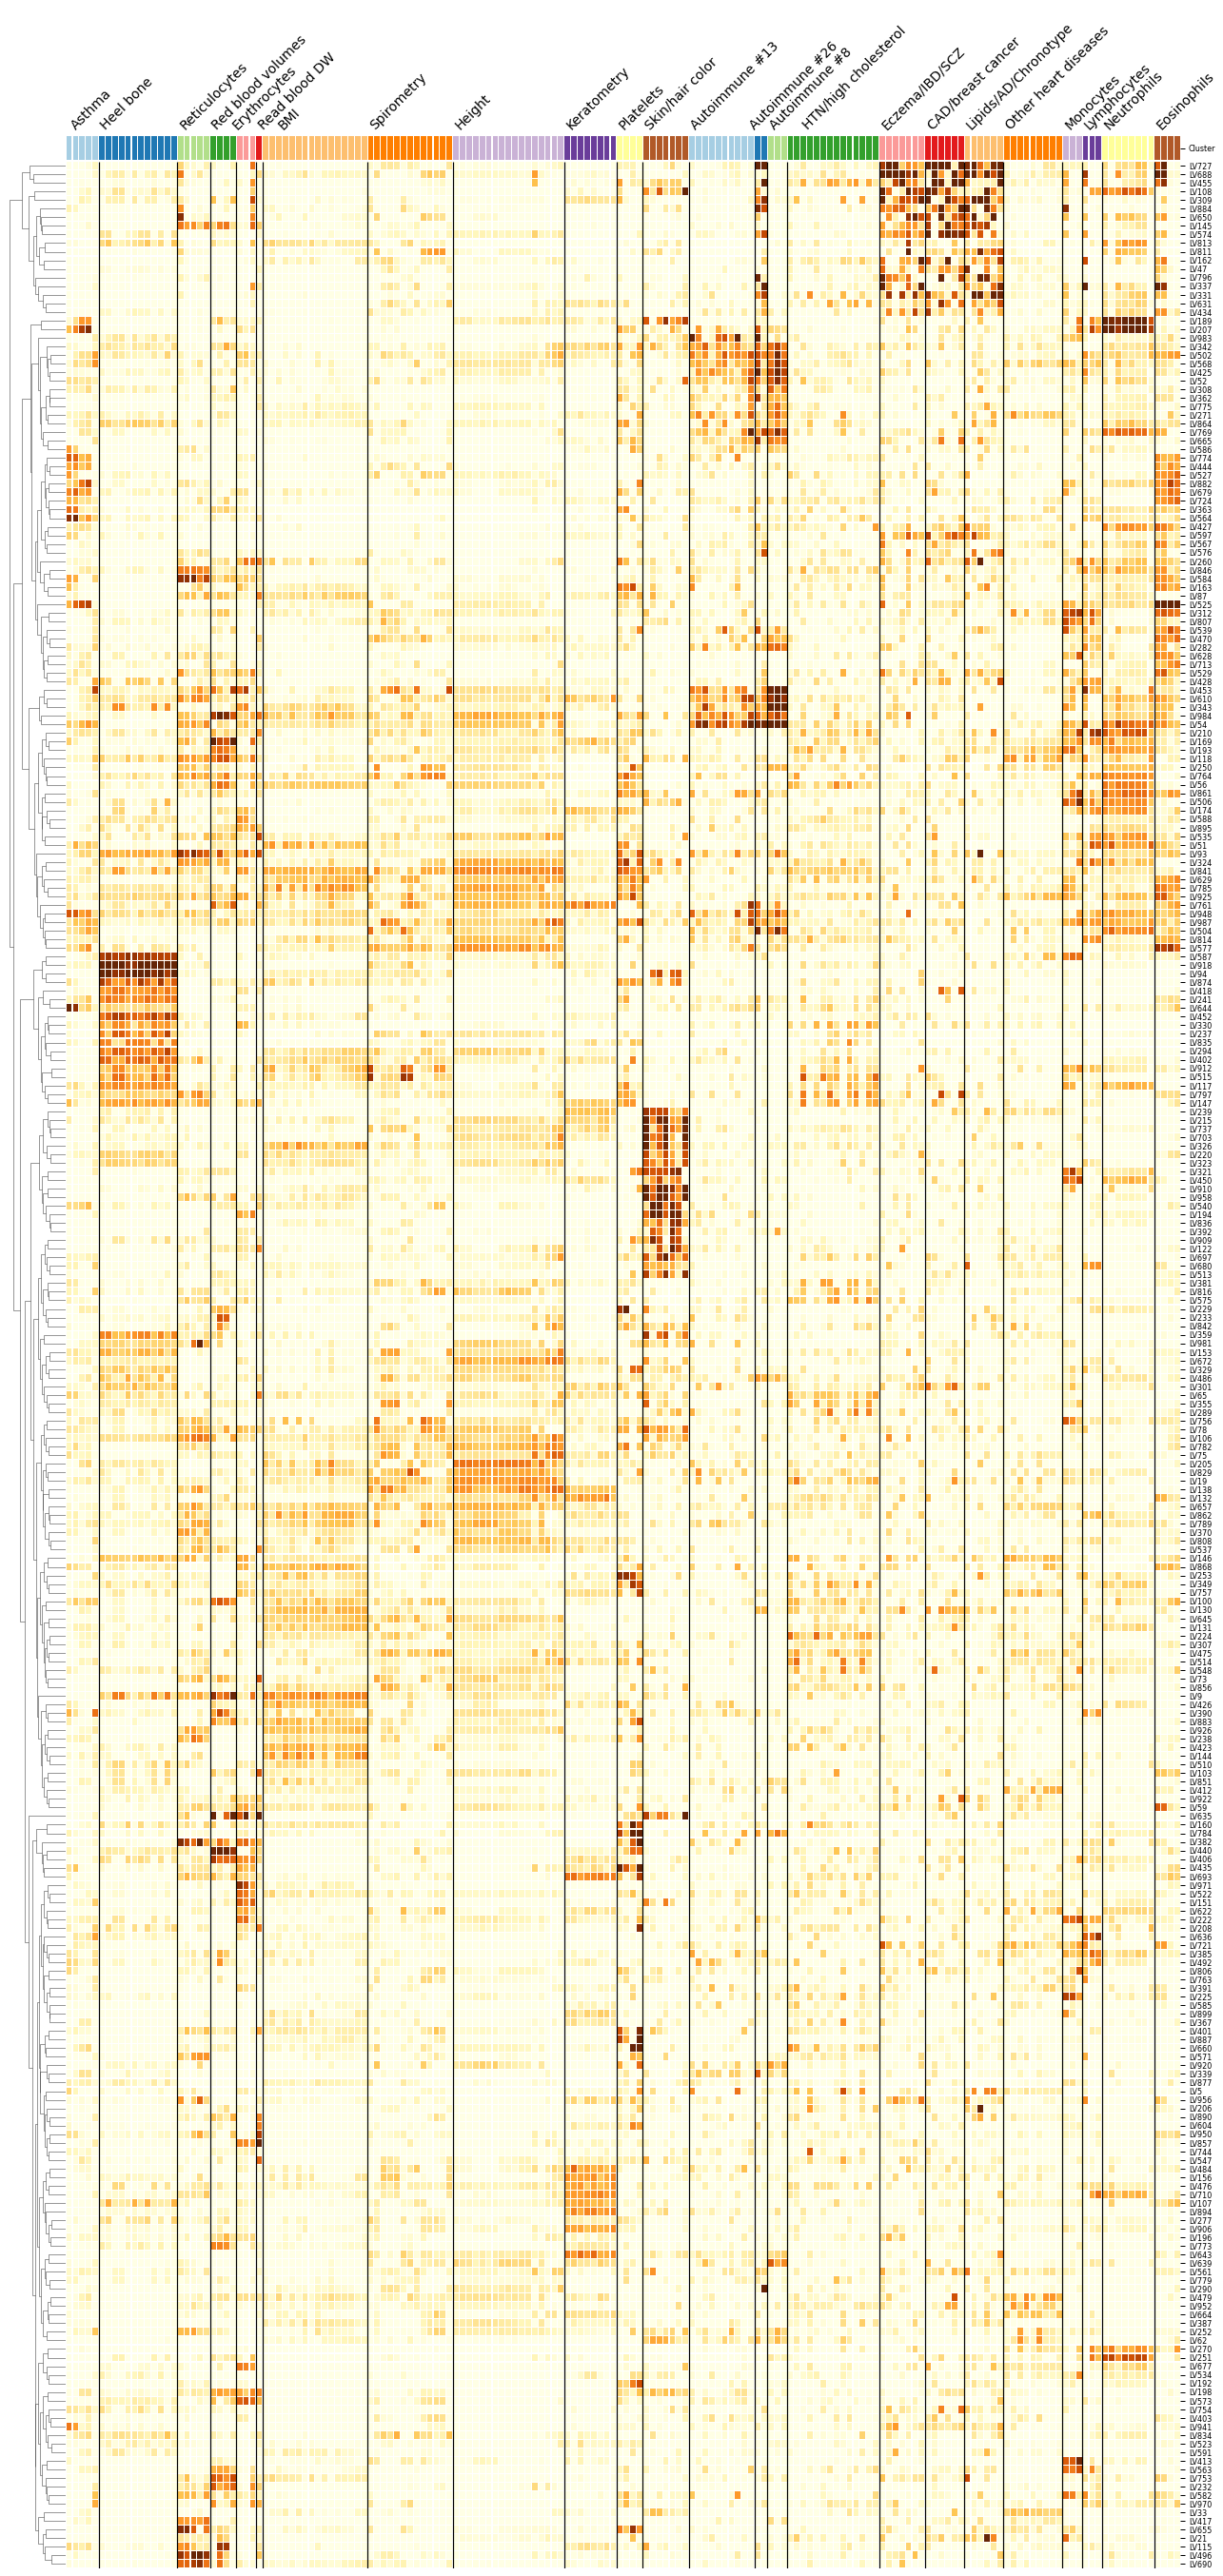

In [94]:
rc = {
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 8,
}

plot_clustermap(rc, None, OUTPUT_FIGURES_DIR / "global_clustermap-novel-plain.svg")